### Inspect data

In [ ]:
import lzma
import json

file_path = 'request_log-20241208.xz'

lengths = []
# Opening the file and processing as JSON
with lzma.open(file_path, mode='rt') as file:
    for i, line in enumerate(file):
        if i >= 50000:  # Stop processing after 50,000 lines
            break
        try:
            # Parsing each line as JSON
            row_dict = json.loads(line.strip())
            a = len(list(row_dict.keys()))
            if a == 16:
                print(f"Row with 16 keys: {row_dict}")
            if a not in lengths:
                lengths.append(a)
        except json.JSONDecodeError as e:
            print(f"JSON parsing error in line {i}: {line.strip()}\n{e}")

print(f"Unique key counts: {lengths}")

{'timestamp': 1733020233770, 'user': 'jobagent', 'role': 'jobagent', 'address': '[2001:b30:4202:100:2000:ffff:0:48c]:42928', 'clientID': '162a58e8-1821-40e6-b4ab-50da058a6ab5', 'requestID': 5293, 'command': 'PutJobLog', 'arguments': ['3214601539', '0', 'proc', '01:19:48 4788 82.27 0.80 3938.99 1001.40 1001.40 32 21 3454 13605.27 1489.43 1489.43 1000'], 'exitCode': 52, 'errorMessage': "Request doesn't pass muster", 'exceptionMessage': 'This job is not supposed to be running any more', 'exceptionTrace': '[alien.api.taskQueue.PutJobLog.run(PutJobLog.java:51), alien.api.Dispatcher.execute(Dispatcher.java:105), alien.api.DispatchSSLServerNIO.executeOneRequest(DispatchSSLServerNIO.java:390), alien.api.DispatchSSLServerNIO.run(DispatchSSLServerNIO.java:470), java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:539), java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264), java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:113

### Load data

In [62]:
import lzma
import json
import trino

# Configuration for connecting to Trino
conn = trino.dbapi.connect(
    host="127.0.0.1", 
    port=8080, 
    user="user",
    catalog="delta", 
    schema="demo" 
)

# Creating a cursor to execute SQL queries
cursor = conn.cursor()

# Path to the .xz file
file_path = 'request_log-20241208.xz'

In [66]:
from tqdm import tqdm

# Function to insert rows into the table
def insert_row(cursor, row):
    query = """
    INSERT INTO demo.request_logs (
        timestamp, user, role, address, clientid, requestid, command,
        arguments, exitcode, errormessage, exceptionmessage, exceptiontrace,
        duration, server, server_pid, server_uuid
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    try:
        cursor.execute(query, row)
    except Exception as e:
        print(f"Error inserting data: {e}")

total_lines = 1000

# Processing the file and loading data
with lzma.open(file_path, mode='rt') as file:
    with tqdm(total=total_lines, desc="Processing lines") as pbar:
        for i, line in enumerate(file):
            if i >= total_lines:  
                break
            try:
                # Parsing the line as JSON
                row_dict = json.loads(line.strip())
                
                # Mapping values to columns
                row = (
                    row_dict.get("timestamp"),
                    row_dict.get("user") or None,
                    row_dict.get("role") or None,
                    row_dict.get("address") or None,
                    row_dict.get("clientID") or None,
                    row_dict.get("requestID") or None,
                    row_dict.get("command") or None,
                    row_dict.get("arguments") or None,
                    row_dict.get("exitCode") or None,
                    row_dict.get("errorMessage") or None,
                    row_dict.get("exceptionMessage") or None,
                    row_dict.get("exceptionTrace") or None,
                    row_dict.get("duration") or None,
                    row_dict.get("server") or None,
                    row_dict.get("server_pid") or None,
                    row_dict.get("server_uuid") or None,
                )
                
                # Inserting into the table
                insert_row(cursor, row)
            
            except json.JSONDecodeError as e:
                print(f"JSON parsing error in line {i}: {line.strip()}\n{e}")
            except Exception as e:
                print(f"Error processing row {i}: {e}")

            # Updating the progress bar
            pbar.update(1)


Processing lines: 100%|██████████| 1000/1000 [01:23<00:00, 11.93it/s] 


In [67]:
cursor.close()
conn.close()

### Visualize

In [68]:
import pandas as pd

# SQL query to fetch the top 10 most active users
query = """
SELECT 
    "user", 
    COUNT(*) AS activity_count
FROM 
    request_logs
GROUP BY 
    "user"
ORDER BY 
    activity_count DESC
LIMIT 10
"""

# Execute the query
cursor = conn.cursor()
cursor.execute(query)

# Fetch the query result and load it into a pandas DataFrame
rows = cursor.fetchall()
data = pd.DataFrame(rows, columns=["user", "activity_count"])

# Display the resulting DataFrame (optional)
print(data)


           user  activity_count
0      thumanic             337
1      jobagent             286
2       crawler             169
3  alihyperloop              82
4         vobox              59
5   alienmaster              35
6      asotoher              14
7        aliana              14
8       swsingh               2
9         admin               1


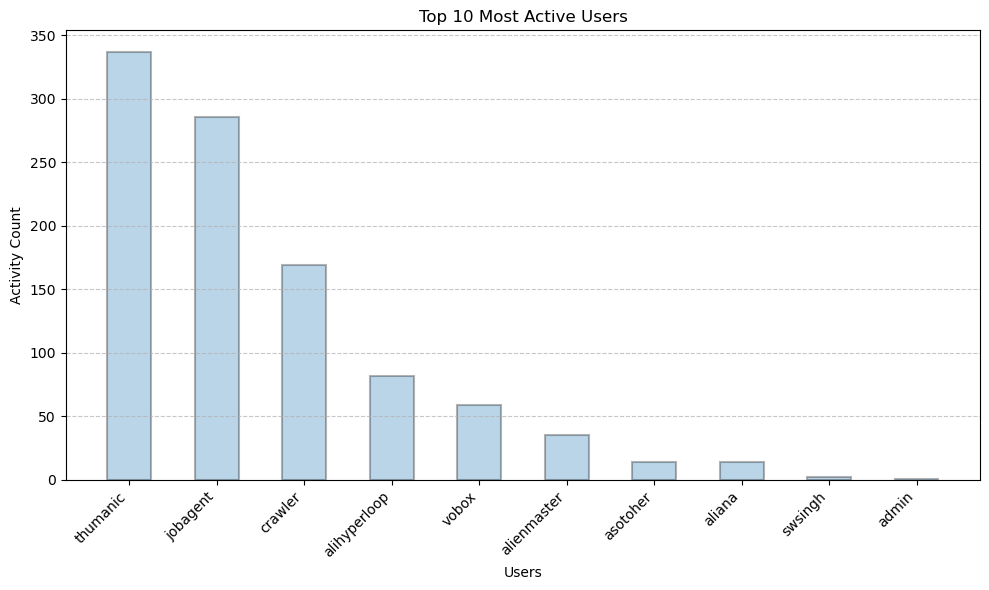

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(data["user"], data["activity_count"], width=0.5, alpha=0.3, linewidth=1.5, fill="royalblue", edgecolor="black")  
plt.xlabel("Users")
plt.ylabel("Activity Count")
plt.title("Top 10 Most Active Users")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7) 
plt.tight_layout()
plt.show()

In [70]:
query = "SELECT duration FROM request_logs WHERE duration IS NOT NULL"
cursor.execute(query)
rows = cursor.fetchall()
durations = [row[0] for row in rows]

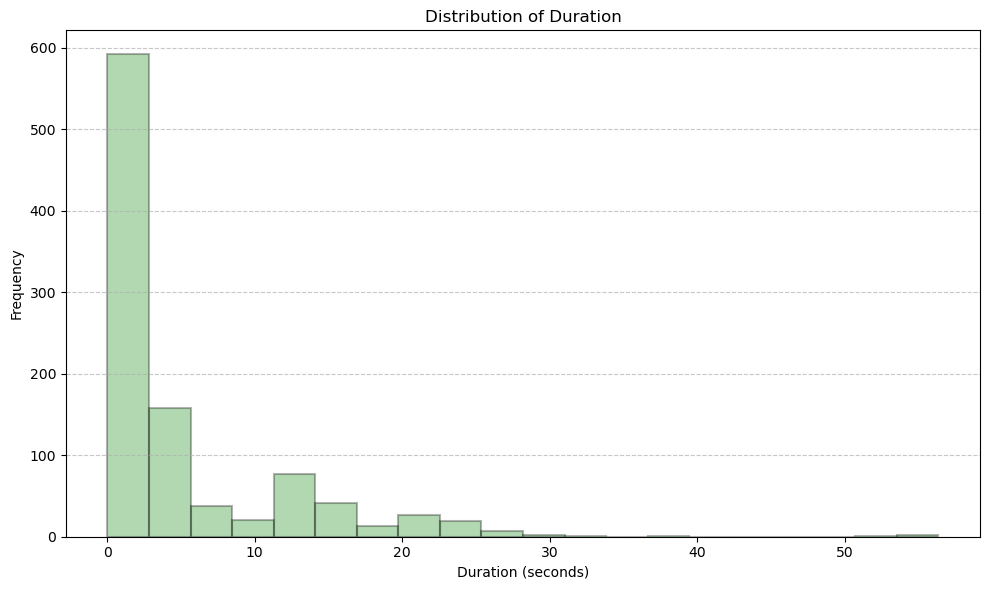

In [71]:
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, color="green", edgecolor="black", linewidth=1.5, alpha=0.3)
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Duration")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [73]:
query = """
SELECT "user", AVG(duration) AS avg_duration
FROM request_logs
WHERE duration IS NOT NULL
GROUP BY "user"
ORDER BY avg_duration DESC
LIMIT 10
"""
cursor.execute(query)
rows = cursor.fetchall()
data = pd.DataFrame(rows, columns=["user", "avg_duration"])

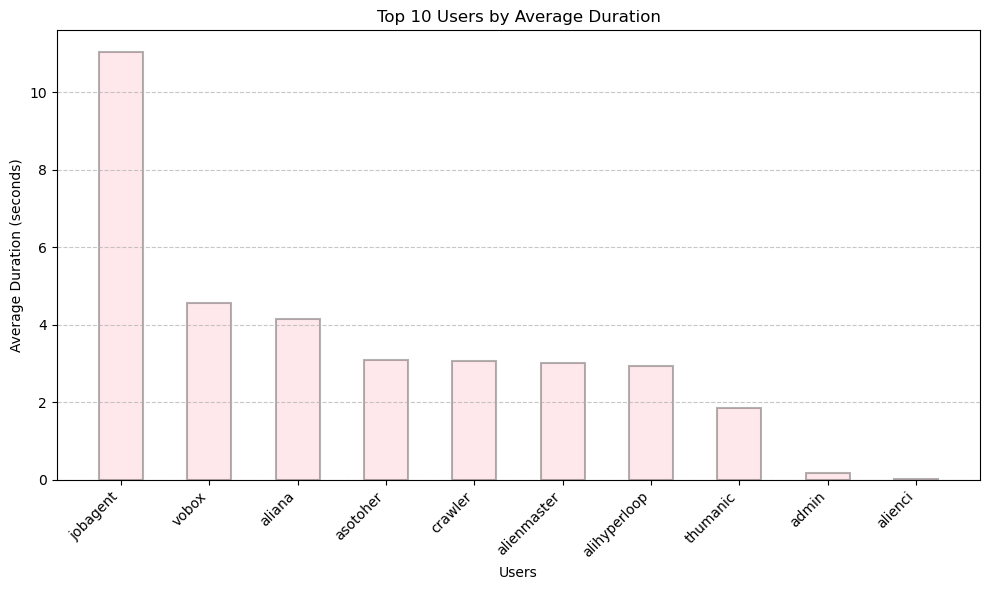

In [74]:
plt.figure(figsize=(10, 6))
plt.bar(data["user"], data["avg_duration"], color="lightpink", edgecolor="black", linewidth=1.5, alpha=0.3, width=0.5)
plt.xlabel("Users")
plt.ylabel("Average Duration (seconds)")
plt.title("Top 10 Users by Average Duration")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()